In [1]:
import msprime as ms
import numpy as np
from itertools import tee
import time

trees are written as a list of branches. Each branch is defined by the binary pattern encoding which sample lineages pass through this branch, w. For n samples, there are Nb=2(n-1)+1=2n-1 branch patterns, including the null pattern (all ancestral alleles). As an array Tb = Nb x n. We also keep track of the tree branch lengths as a list, Td = Nb x 1

Branch/mutation patterns w are written as integers. The length n list of 0/1 values encoding the ancestral/derived state of the haplotypes over the n samples are interpretated as binary numbers, which we convert to integer representation for ease. 

the observed data for a sample is written as a list of genotypes at each site. Each site is defined by the binary pattern encoding which samples have derived mutations, w. As an array, this is S = L x n.


In [2]:
#####################################################
# Utility Functions
#####################################################

def convert_tree_tskit_to_native(ts_tree):
    n = ts_tree.get_num_samples() 
    zeros = np.zeros(n,dtype=int)
    
    # The first element in the tree lists Tb and Td describe the all-ancestral case, 
    # where the distance recorded is the total tree size.
    # Tb records the branch patterns as tuples
    # Td records the branch distance (length)
    Tb = [0]
    Td = [ts_tree.total_branch_length]
    
    nodes = sorted(list(ts_tree.nodes()))
    
    # For n samples there are 2n-1 nodes, including the root node. 
    # We don't include the root node below, as the root branch has indeterminate length.
    # Hence there are 2n-2 internal nodes that we iterate over.
    for k in range(2*(n-1)):
        i = nodes[k]
        d = ts_tree.branch_length(i)
        W = zeros.copy()
        W[list(ts_tree.get_leaves(i))] = 1
        
        w = np.sum([2**k for k in ts_tree.get_leaves(i)])
        
        Tb.append(w)
        Td.append(d)
    
    return Tb,Td

def convert_ARG_tskit_to_native(ts_tree_seq):
    ARG = []
    for tree in ts_tree_seq.trees():
        x0,x1 = tree.interval
        x0 = int(x0)
        x1 = int(x1)
        if x1 == x0:
            x1 += 1
        Tb,Td = convert_tree_tskit_to_native(tree)
        ARG.append([x0,x1,Tb,Td])
        
    return ARG

def reorder_WPDO(M,sample_nums):
    # M is any L x n array, where n=sum(sample_nums).
    # Will reorder the columns such that, within each group, the columns are ordered by most counts of 1s in that column.
    M = np.array(M)
    Mord = np.zeros(M.shape)
    c = np.sum(M,axis=0)
    i0=0
    for i,ni in enumerate(sample_nums):
        i1 = i0 + ni
        ci = c[i0:i1]
        Mi = M[:,i0:i1]
        
        orderi = np.argsort(-ci)    # ordered by largest to smallest
        Mord[:,i0:i1] = Mi[:,orderi]
        i0=i1
    return list(map(tuple,Mord.tolist()))

def reorder_WPDO_ARG(ARG,sample_nums):
    for tree in ARG:
        Tb = tree[2]
        tree[2] = reorder_WPDO(Tb,sample_nums)
    return ARG

def run_msprime_native(theta,sample_nums,L,r,mu,R,order='natural'):
    ARGs = []
    ts_replicates = run_msprime_tskit(theta,sample_nums,L,r,mu,R)
    for ts_tree_seq in ts_replicates:
        ARG = convert_ARG_tskit_to_native(ts_tree_seq)
        
        if order == 'natural':
            ARGs.append(ARG)
        elif order == 'WPDO':
            ARG_ord = reorder_WPDO_ARG(ARG,sample_nums)    
            ARGs.append(ARG_ord)
            
    return iter(ARGs)

def create_sample_draws(draws_max,pop_assign,sample_scheme):
    """
    Compute draws of the observed samples to use for likelihood calculation
    """
    draws = []
    
    n = np.sum(sample_scheme)
    Np = len(sample_scheme)
    draws = []
    while (len(draws) < draws_max):
        draw = []
        for i in range(Np):
            ni = sample_scheme[i]
            samples_i = sorted(np.random.choice(pop_assign[i],size=ni,replace=False))
            draw.extend(samples_i)
            
        draw_tup = tuple(draw)
        if draw_tup not in draws:
            draws.append(draw_tup)
    return draws


In [3]:
#####################################################
# msprime Functions
#####################################################

def run_msprime_tskit(theta,sample_nums,L,r,mu,R):
    ts_replicates = None
    
    Np = len(sample_nums)
    init_pop_configs = [ms.PopulationConfiguration(sample_size=sample_nums[i], initial_size=theta[0][1][0][i]) for i in range(Np)]
    init_mig = theta[0][1][1]
    
    K = len(theta)  # K = number of epochs
    if K > 1:
        # There is more than one epoch, so must set the non-initial epochs as demographic events
        demo_events = []
        for k in range(1,K):
            t_k,theta_k = theta[k]
            Ne = theta_k[0]
            mig = theta_k[1]
            for i in range(Np):
                # Set the Ne
                demo_events.append(ms.PopulationParametersChange(population=i,time=t_k,initial_size=Ne[i]))

                # Set the migration rates
                for j in range(Np):
                    if j!=i:
                        demo_events.append(ms.MigrationRateChange(time=t_k,rate=mig[i,j],matrix_index=tuple([i,j])))

        ts_replicates = ms.simulate(
            length=L,
            recombination_rate=r,
            population_configurations=init_pop_configs,
            migration_matrix = init_mig,
            demographic_events=demo_events,
            num_replicates=R,
            mutation_rate = mu
        )
    else:
        # There is only the initial epoch. 
        ts_replicates = ms.simulate(
            length=L,
            recombination_rate=r,
            population_configurations=init_pop_configs,
            migration_matrix = init_mig,
            num_replicates=R,
            mutation_rate = mu
        )
    return ts_replicates

def demo_debug(theta,sample_scheme):
    Np = len(sample_scheme)
    init_pop_configs = [ms.PopulationConfiguration(sample_size=sample_scheme[i], initial_size=theta[0][1][0][i]) for i in range(Np)]
    init_mig = theta[0][1][1]
    
    # Set the demographic model for the given parameters theta for non-initial events
    K = len(theta)
    if K > 1:
        demo_events = []
        for k in range(1,K):
            t_k,theta_k = theta[k]
            Ne = theta_k[0]
            mig = theta_k[1]
            for i in range(Np):
                # Set the Ne
                demo_events.append(ms.PopulationParametersChange(population=i,time=t_k,initial_size=Ne[i]))

                # Set the migration rates
                for j in range(Np):
                    if j!=i:
                        demo_events.append(ms.MigrationRateChange(time=t_k,rate=mig[i,j],matrix_index=tuple([i,j])))

        # Simulate R ARGs from this model
        dd = ms.DemographyDebugger(
            population_configurations=init_pop_configs,
            migration_matrix = init_mig,
            demographic_events=demo_events
        )
        dd.print_history()
    else:
        dd = ms.DemographyDebugger(
        population_configurations=init_pop_configs,
        migration_matrix = init_mig
        )
        dd.print_history()
    
    return 1

def simulate_sequence_data(theta,sample_nums,L,r,mu):
    # Does not incorporate recombination maps. 
    S = []  # To return an L x N array, where N=sum(sample_nums)
    
    N = np.sum(sample_nums)
    print('Target number of sites in the seq:',L)    
    S = np.zeros((L,N),dtype=int)
    
    ts_replicates = run_msprime_tskit(theta,sample_nums,L,r,mu,1)   # There is only 1 ARG in the replicates iterator
    
    for tree_seq in ts_replicates:
        Nvar = 0
        Nfix_der = 0
        Nfix_anc = 0
        
        x_last = 0
        for variant in tree_seq.variants():
            x = int(variant.site.position)
            
            d = x-x_last
            nanc = np.max([d-1,0])   
            Nfix_anc += nanc
            
            S[x,:] = list(variant.genotypes)
            nd = np.sum(S[x,:])
            if nd == 0:
                Nfix_anc += 1
            else:
                Nvar += 1
                if nd == N:
                    Nfix_der += 1
            x_last = x

    print('Nvar:',Nvar)
    print('Nfix_der',Nfix_der)
    print('Nfix_anc:',Nfix_anc)
    print('Ntot:',Nvar+Nfix_anc)
    
    return S



In [4]:
#####################################################
# Likelihood Functions for tskit ARGs
#####################################################
def loglikelihood_tree_ts(ts_tree,s,mu,tol=0.05):
    """
    Calculates the log likelihood of the data given the tree and the mutation rate.
    Returns loglike=nan if there are more than tol incompatible sites.
    """
    probs = []
    counts = []
    tree_size = ts_tree.total_branch_length
    n = ts_tree.get_num_samples() 
    L = len(s)

    s_uniq,s_counts = np.unique(s,return_counts=True)

    N_fixanc = 0
    for i,w in enumerate(Tb):
        if w in s_uniq:
            c = s_counts[s_uniq.index(w)]
            if i == 0:
                N_fixanc = c
                counts.append(c)
                prob_nomut_tree = np.exp(-mu*tree_size)
                probs.append(prob_nomut_tree)
            else:
                counts.append(c)
                d = Td[i]

                prob_mut_branch = (1 - np.exp(-mu*d))
                prob_nomut_notbranch = np.exp(-mu*(tree_size-d))

                prob = prob_mut_branch * prob_nomut_notbranch
                probs.append(prob)
    count = np.sum(counts)
    
    # Only count sites that are not fixed for the derived allele over the n samples. These define the "_use" sites.
    # Because for fixed derived sites we cannot compute a likelihood with the samples drawn.
    
    w_fixder = 2**n-1
    N_fixder = 0
    if w_fixder in s_uniq:
        N_fixder = s_counts[s_uniq.index(w_fixder)]
    N_use = L - N_fixder
    
    # The "_var" sites denote variable (polymorphic) sites over the n samples
    count_var = count - N_fixanc
    N_var = N_use - N_fixanc
    
    # Only compute loglike if there are less than tol incompatibilities between the observed mutation patterns and the tree among usable sites
    loglike=np.nan
    rel = 0.
    if N_use > 0:
        rel = (N_use-count)/N_use
    if rel <= tol:
        loglike = np.sum(counts*np.log(probs))
    
    return loglike,count,N_use,count_var,N_var

def loglikelihood_ARG_ts(ARG,S,sample_nums,window,draw,mu,tol=0.05,order='natural'):
    """
    Calculates the log likelihood of the data given the ARG and mutation rate, 
    within a specific window and for a specific draw of samples.
    """
    Ls,n = S.shape
    loglikes = []
    counts = []
    N_use = 0
    count = 0
    count_var = 0
    N_var = 0
    
    p0,p1 = window
    Lw = p1-p0
    
    nTrees = 0
    nTrees_use = 0
    
    S_ARG = S[p0:p1,draw]
    s_ARG = [np.sum([b*2**k for k,b in enumerate(w)]) for w in S_ARG.tolist()]
    for tree in ARG:
        nTrees += 1
        x0,x1 = tree.interval
        x0 = int(x0)
        x1 = int(x1)
        if x1 == x0:
            x1 += 1
        Ltree = x1 - x0
        
        if Ltree > 0:
            s_tree = s_ARG[x0:x1]
            #S_tree_list = list(map(tuple,S_tree.tolist()))

            loglike_tree,count_tree,N_use_tree,count_var_tree,N_var_tree = loglikelihood_tree_ts(tree,s_tree,mu,tol=tol)
            
            N_use += N_use_tree
            count += count_tree
            
            count_var += count_var_tree
            N_var += N_var_tree
            
            if not np.isnan(loglike_tree):
                nTrees_use += 1
                loglikes.append(loglike_tree)
                counts.append(count_tree)
        
    # Only use results if there are less than a fraction tol incompatibilities among all variable sites
    loglike_ARG_per = np.nan
    rel = 0.
    if N_use > 0:
        rel = (N_use-count)/N_use
    if rel <= tol and len(loglikes)>0:
        loglike_ARG_per = np.sum(loglikes)/np.sum(counts)
    
    # Return the loglikelihood per site and the count of sites
    return loglike_ARG_per,count,N_use,count_var,N_var

def likelihood_model_ts(theta,S,sample_nums,windows,draws,L,r,mu,R,tol=0.05,order='natural',ARGs=None):
    """
    Calculates an estimate of ln[P(data|model)]
    """
    Nwindows = len(windows)
    Ndraws = len(draws)
    Ncalcs = Nwindows*Ndraws
   
    
    if ARGs is None:
        # Make set of R replicate ARGs
        ARGs = run_msprime_tskit(theta,sample_nums,L,r,mu,R)

    # Make copy of the replicates iterator, one for use and one to pass on for potential later inspection/use. 
    ARGsCopy,ARGsUse = tee(ARGs)

    ##################################################
    # Compute the average likelihood over the replicates, windows, and draws. 
    # Here I'm just taking global average, as a simple placeholder.
    
    loglikes = []  # loglikelihood per site
    fracs = []   # fraction of sites for each ARG that are compatable with the ARG
    fracs_var = [] # fraction of sites for each ARG that are compatable with the ARG and are not fixed ancestral
   
    iARG = 0
    for ARG in ARGsUse:
        iARG += 1
        
        #for tree in ARG.trees():
        #    print(tree.draw(format="unicode"))
        
        ARG_its = tee(ARG.trees(),Ncalcs)
        
        for iwin,window in enumerate(windows):
            for idraw,draw in enumerate(draws):
                k = iwin*Ndraws + idraw
                loglike_ARG_per,count,N_use,count_var,N_var = loglikelihood_ARG_ts(ARG_its[k],S,sample_nums,window,draw,mu,tol=tol,order=order)
                
                if not np.isnan(loglike_ARG_per):
                    loglikes.append(loglike_ARG_per)

                fracs.append(count/N_use)
                fracs_var.append(count_var/N_var)
    
    loglike = np.nan
    nSeg_use = len(loglikes)
    if nSeg_use > 0:
        loglike = np.mean(loglikes)
    
    return loglike,nSeg_use,np.nanmean(fracs),np.nanmean(fracs_var),ARGsCopy



In [5]:
#####################################################
# Likelihood Functions
#####################################################
def loglikelihood_tree(Tb,Td,s,n,mu,tol=0.05):
    """
    Calculates the log likelihood of the data given the tree and the mutation rate.
    Returns loglike=nan if there are more than tol incompatible sites.
    """
    probs = []
    counts = []
    tree_size = Td[0]
    L = len(s)

    s_uniq,s_counts = np.unique(s,return_counts=True)
    s_uniq = list(s_uniq)
    
    N_fixanc = 0
    for i,w in enumerate(Tb):
        if w in s_uniq:
            c = s_counts[s_uniq.index(w)]
            if i == 0:
                N_fixanc = c
                counts.append(c)
                prob_nomut_tree = np.exp(-mu*tree_size)
                probs.append(prob_nomut_tree)
            else:
                counts.append(c)
                d = Td[i]

                prob_mut_branch = (1 - np.exp(-mu*d))
                prob_nomut_notbranch = np.exp(-mu*(tree_size-d))

                prob = prob_mut_branch * prob_nomut_notbranch
                probs.append(prob)
    count = np.sum(counts)
    
    # Only count sites that are not fixed for the derived allele over the n samples. These define the "_use" sites.
    # Because for fixed derived sites we cannot compute a likelihood with the samples drawn.
    w_fixder = 2**n - 1
    N_fixder = 0
    if w_fixder in s_uniq:
        N_fixder = s_counts[s_uniq.index(w_fixder)]
    N_use = L - N_fixder
    
    # The "_var" sites denote variable (polymorphic) sites over the n samples
    count_var = count - N_fixanc
    N_var = N_use - N_fixanc
    
    # Only compute loglike if there are less than tol incompatibilities between the observed mutation patterns and the tree among usable sites
    loglike=np.nan
    rel = 0.
    if N_use > 0:
        rel = (N_use-count)/N_use
    if rel <= tol:
        loglike = np.sum(counts*np.log(probs))
    
    return loglike,count,N_use,count_var,N_var

def loglikelihood_ARG(ARG,S,sample_nums,window,draw,mu,tol=0.05,order='natural'):
    """
    Calculates the log likelihood of the data given the ARG and mutation rate, 
    within a specific window and for a specific draw of samples.
    """
    Ls,N = S.shape
    n = len(draw)
    
    loglikes = []
    counts = []
    N_use = 0
    count = 0
    count_var = 0
    N_var = 0
    
    p0,p1 = window
    Lw = p1-p0
    
    nTrees = 0
    nTrees_use = 0
    
    S_ARG = S[p0:p1,draw]
    
    # Reorder the sample labels over this window if desired
    #S_ARG_ord = []
    #if order == 'natural':
    #    S_ARG_ord = S_ARG
    #elif order == 'WPDO':
    #    S_ARG_ord_list = reorder_WPDO(S_ARG,sample_nums)
    #    S_ARG_ord = np.array(S_ARG_ord_list)
    
    #S_ARG_uniq,S_ARG_ind,S_ARG_counts = np.unique(S_ARG_ord,return_inverse=True,return_counts=True,axis = 0)
    #print('Suniq',Suniq)
    #S_ARG_uniq_list = list(map(tuple,Suniq.tolist()))
    s_ARG = [np.sum([b*2**k for k,b in enumerate(w)]) for w in S_ARG.tolist()]
    for tree in ARG:
        nTrees += 1
        x0,x1,Tb,Td = tree
        Ltree = x1 - x0
        
        if Ltree > 0:
            s_tree = s_ARG[x0:x1]
            #S_tree_list = list(map(tuple,S_tree.tolist()))
            #loglike_tree,count_tree,N_use_tree,count_var_tree,N_var_tree = loglikelihood_tree(Tb,Td,S_tree_list,mu,tol=tol)
            
            #S_tree_ind = S_ARG_ind[x0:x1]
            #S_tree_counts = S_ARG_counts[S_tree_ind]
            #S_tree_uniq_list = S_ARG_uniq_list[S_tree_ind]
            loglike_tree,count_tree,N_use_tree,count_var_tree,N_var_tree = loglikelihood_tree(Tb,Td,s_tree,n,mu,tol=tol)
            
            N_use += N_use_tree
            count += count_tree
            
            count_var += count_var_tree
            N_var += N_var_tree
            
            if not np.isnan(loglike_tree):
                nTrees_use += 1
                loglikes.append(loglike_tree)
                counts.append(count_tree)
        
    # Only use results if there are less than a fraction tol incompatibilities among all variable sites
    loglike_ARG_per = np.nan
    rel = 0.
    if N_use > 0:
        rel = (N_use-count)/N_use
    if rel <= tol and len(loglikes)>0:
        loglike_ARG_per = np.sum(loglikes)/np.sum(counts)
    
    # Return the loglikelihood per site and the count of sites
    return loglike_ARG_per,count,N_use,count_var,N_var
    
def likelihood_model(theta,S,sample_nums,windows,draws,L,r,mu,R,tol=0.05,order='natural',ARGs=None):
    """
    Calculates an estimate of ln[P(data|model)]
    """
    
    #replicatesCopy = None
    
    if ARGs is None:
        # Make set of R replicate ARGs
        ARGs = run_msprime_native(theta,sample_nums,L,r,mu,R,order=order)

    # Make copy of the replicates iterator, one for use and one to pass on for potential later inspection/use. 
    ARGsCopy,ARGsUse = tee(ARGs)

    ##################################################
    # Compute the average likelihood over the replicates, windows, and draws. 
    # Here I'm just taking global average, as a simple placeholder.
    
    loglikes = []  # loglikelihood per site
    fracs = []   # fraction of sites for each ARG that are compatable with the ARG
    fracs_var = [] # fraction of sites for each ARG that are compatable with the ARG and are not fixed ancestral
   
    iARG = 0
    for ARG in ARGsUse:
        iARG += 1
        
        iwin = 0
        for window in windows:
            iwin += 1

            idraw = 0
            for draw in draws:
                idraw += 1
                
                loglike_ARG_per,count,N_use,count_var,N_var = loglikelihood_ARG(ARG,S,sample_nums,window,draw,mu,tol=tol,order=order)
                
                if not np.isnan(loglike_ARG_per):
                    loglikes.append(loglike_ARG_per)

                fracs.append(count/N_use)
                fracs_var.append(count_var/N_var)
    
    loglike = np.nan
    nSeg_use = len(loglikes)
    if nSeg_use > 0:
        loglike = np.mean(loglikes)
    
    return loglike,nSeg_use,np.nanmean(fracs),np.nanmean(fracs_var),ARGsCopy


In [11]:
####################################################################################################
# Check a simple three population two epoch model, for 1 window, and 1 draw over all individuals in the data

####################################################################################################
# Set the initial values...
##################################################
# Fixed model parameters...
mu=1e-7                                  # mutation rate per site per generation per lineage
r=2e-8                                   # recombination rate per site per generation per lineage
Lobs = int(2e4)                          # The total number of sites in the observed sequence data
R=20                                     # Num of replicate ARGs to run per model
L=Lobs                                   # size of each ARG window 
windows = [[0,L]]                        # List of the windows to use
draws_max = 1                            # Maximum number of sample draws to use
tol = 0.5                                # Tolerance in fraction of mutational patterns that don't match the ARG tree among usable sites
order='natural'                             # The sample label order to use. 'natural'= do nothing. 'WPDO'= put samples in Within-Population Derived-allele Order

# Set the demographic model parameters (theta)...
Np = 3                                  # Num pops
pop_sizes = [4 for i in range(Np)]      # Num of samples per population in the observed data
sample_scheme = [4 for i in range(Np)]  # Num samples drawn from each pop for likelihood

# pop sizes
N_base = 1e4    # Number of diploids in the population
Ne0 = np.ones(Np)*N_base

# Set migration rates
M_base = 1e-4
m0 = np.zeros((Np,Np))
m1 = m0.copy()
for i in range(Np):
    for j in range(Np):
        if j!=i:
            m1[i,j] = M_base/(2*(Np-1))

phi0 = [Ne0,m0]
phi1 = [Ne0,m1]
t1 = 1e4
theta_true=[[0.,phi0],[t1,phi1]] #TODO Read this in as a file; each theta = one epoch
demo_debug(theta_true,pop_sizes)

####################################################################################################
# Values below are set by the above initialization (don't need to set anything further)...
##################################################
# Utility
pops = [i for i in range(Np)]
n = np.sum(sample_scheme)
N = np.sum(pop_sizes)
pop_assign = []  # row index = pop index. value = list of indices of samples assigned to each pop.
j = 0
for i in range(Np):
    Ni = pop_sizes[i]
    indices = list(range(j,j+Ni))
    pop_assign.append(indices)
    j+=Ni

# Generate the fake seq data from the true model, S
S = simulate_sequence_data(theta_true,pop_sizes,Lobs,r,mu)
Lobs_sim,N = S.shape
if Lobs_sim > Lobs:
    S = S[:Lobs,:]
Lobs,N = S.shape   # reset the observed seq length, as the simulation doesn't return exact results at discrete bp
print('Final length of observed data:',Lobs)

# Take the sample draws to use
draws = create_sample_draws(draws_max,pop_assign,sample_scheme)
####################################################################################################

Epoch: 0 -- 10000.0 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |  1e+04    1e+04               0 |     0        0        0    
1 |  1e+04    1e+04               0 |     0        0        0    
2 |  1e+04    1e+04               0 |     0        0        0    

Events @ generation 10000.0
   - Population parameter change for 0: initial_size -> 10000.0 
   - Migration rate change for (0, 1) to 2.5e-05
   - Migration rate change for (0, 2) to 2.5e-05
   - Population parameter change for 1: initial_size -> 10000.0 
   - Migration rate change for (1, 0) to 2.5e-05
   - Migration rate change for (1, 2) to 2.5e-05
   - Population parameter change for 2: initial_size -> 10000.0 
   - Migration rate change for (2, 0) to 2.5e-05
   - Migration rate change for (2, 1) to 2.5e-05
Epoch: 10000.0 -- inf generations
     start     end      growth_rate |     0        1        2    
   -------- --------

In [9]:
# Compute likelihood of the true model that is used to generate the fake data
ts = time.time()
loglike,nSeg_use,f,f_var,ARGs = likelihood_model_ts(theta_true,S,sample_scheme,windows,draws,L,r,mu,R,tol=tol,order=order)
te = time.time()
print('time likelihood_model(): %1.1e' % (te-ts))
print('Num segments over ARGS, windows, and draws used:', nSeg_use)
print('loglike per site:',loglike)
print('fraction of sites that are compatable:',f)
print('fraction of polymorphic sites that are compatable:',f_var)


NameError: name 'Tb' is not defined

In [18]:
# Compute likelihood of the true model that is used to generate the fake data
ts = time.time()
loglike,nSeg_use,f,f_var,ARGs = likelihood_model(theta_true,S,sample_scheme,windows,draws,L,r,mu,R,tol=tol,order=order)
te = time.time()
print('time likelihood_model(): %1.1e' % (te-ts))
print('Num segments over ARGS, windows, and draws used:', nSeg_use)
print('loglike per site:',loglike)
print('fraction of sites that are compatable:',f)
print('fraction of polymorphic sites that are compatable:',f_var)

time likelihood_model(): 5.5e+00
Num segments over ARGS, windows, and draws used: 20
loglike per site: -0.15842502638462203
fraction of sites that are compatable: 0.9769931054452435
fraction of polymorphic sites that are compatable: 0.39696070896776986


In [83]:
# Compute likelihood of a wrong model, for example. Doubling the population size...
phi0 = [Ne0,m0]
phi1 = [Ne0*0.1,m1]
theta_init=[[0.,phi0],[t1,phi1]]
demo_debug(theta_init,pop_sizes)
ts = time.time()
loglike,nSeg_use,f,f_var,ARGs = likelihood_model(theta_true,S,sample_scheme,windows,draws,L,r,mu,R,tol=tol,order=order)
te = time.time()
print('time likelihood_model(): %1.1e' % (te-ts))
print('Num segments over ARGS, windows, and draws used:', nSeg_use)
print('loglike per site:',loglike)
print('fraction of sites that are compatable:',f)
print('fraction of polymorphic sites that are compatable:',f_var)



Epoch: 0 -- 10000.0 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |  1e+04    1e+04               0 |     0        0        0    
1 |  1e+04    1e+04               0 |     0        0        0    
2 |  1e+04    1e+04               0 |     0        0        0    

Events @ generation 10000.0
   - Population parameter change for 0: initial_size -> 1000.0 
   - Migration rate change for (0, 1) to 2.5e-05
   - Migration rate change for (0, 2) to 2.5e-05
   - Population parameter change for 1: initial_size -> 1000.0 
   - Migration rate change for (1, 0) to 2.5e-05
   - Migration rate change for (1, 2) to 2.5e-05
   - Population parameter change for 2: initial_size -> 1000.0 
   - Migration rate change for (2, 0) to 2.5e-05
   - Migration rate change for (2, 1) to 2.5e-05
Epoch: 10000.0 -- inf generations
     start     end      growth_rate |     0        1        2    
   -------- --------   

In [7]:
X = []
Y = []
Z = []
F = []
Fv = []
for p in [-2,-1,-0.5,-0.2,0,0.2,0.5,1,2]:
    print('p',p)
    a = 2.**p
    phi0 = [Ne0*a,m0]
    phi1 = [Ne0,m1]
    theta_init=[[0.,phi0],[t1,phi1]]
    loglike,nSeg_use,f,f_var,ARGs = likelihood_model(theta_init,S,sample_scheme,windows,draws,L,r,mu,R,tol=tol,order=order)
    X.append(N_base*a)
    Y.append(nSeg_use)
    Z.append(loglike)
    F.append(f)
    Fv.append(f_var)
    

p -2
p -1
p -0.5
p -0.2
p 0
p 0.2
p 0.5
p 1
p 2


In [93]:
X

[2500.0,
 5000.0,
 7071.067811865476,
 8705.505632961242,
 10000.0,
 11486.983549970351,
 14142.135623730952,
 20000.0,
 40000.0]

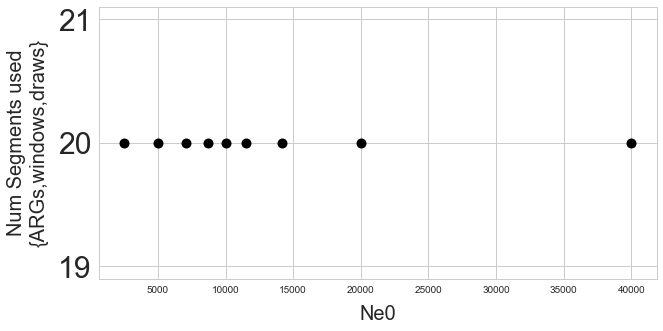

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

home='mebh'
work='mhansen'
this=work

label='Ne0'

figout='/Users/%s/Dropbox/Science/Projects/DemographicInference/%s_vs_NumSegUse.pdf' % (this,label)
figh=5
figw=10
sns.set(rc = {'ytick.labelsize': 30.0},style="whitegrid")
fig=plt.figure(figsize=(figw, figh))
ax = plt.subplot(111)
plt.plot(X,Y,markersize=10,
                     linestyle='none',
                     fillstyle='none',
                    marker='o',
                    markerfacecolor='k',
                    alpha=1,
                    markeredgecolor='k',
                    markeredgewidth=0,
                    zorder=10)
plt.xlabel('%s' % label ,fontsize=20,labelpad=10)
plt.ylabel('Num Segments used\n{ARGs,windows,draws}',fontsize=20,labelpad=10)

plt.savefig(figout,bbox_inches = 'tight', pad_inches = 0.1)
#,bbox_inches = 'tight', pad_inches = 0.1
plt.show()
plt.close()

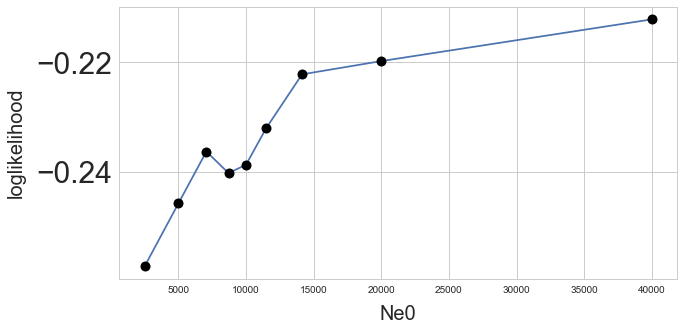

In [11]:
figout='/Users/%s/Dropbox/Science/Projects/DemographicInference/%s_vs_loglike.pdf' % (this,label)
figh=5
figw=10
sns.set(rc = {'ytick.labelsize': 30.0},style="whitegrid")
fig=plt.figure(figsize=(figw, figh))
ax = plt.subplot(111)
plt.plot(X,Z,markersize=10,
                     linestyle='-',
                     fillstyle='none',
                    marker='o',
                    markerfacecolor='k',
                    alpha=1,
                    markeredgecolor='k',
                    markeredgewidth=0,
                    zorder=10)
plt.xlabel('%s' % label ,fontsize=20,labelpad=10)
plt.ylabel(r'loglikelihood',fontsize=20,labelpad=10)

plt.savefig(figout,bbox_inches = 'tight', pad_inches = 0.1)
#,bbox_inches = 'tight', pad_inches = 0.1
plt.show()
plt.close()

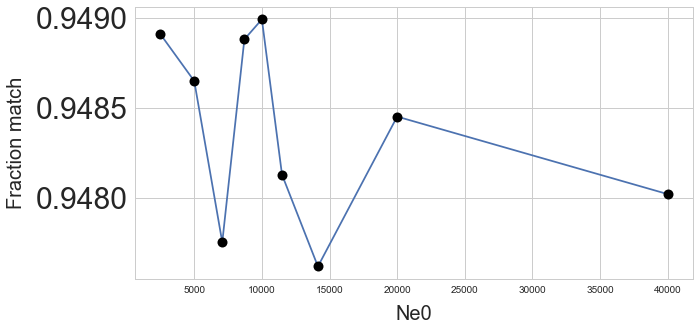

In [106]:
figout='/Users/%s/Dropbox/Science/Projects/DemographicInference/%s_vs_fracmatch.pdf' % (this,label)
figh=5
figw=10
sns.set(rc = {'ytick.labelsize': 30.0},style="whitegrid")
fig=plt.figure(figsize=(figw, figh))
ax = plt.subplot(111)
plt.plot(X,F,markersize=10,
                     linestyle='-',
                     fillstyle='none',
                    marker='o',
                    markerfacecolor='k',
                    alpha=1,
                    markeredgecolor='k',
                    markeredgewidth=0,
                    zorder=10)
plt.xlabel('%s' % label ,fontsize=20,labelpad=10)
plt.ylabel(r'Fraction match',fontsize=20,labelpad=10)

plt.savefig(figout,bbox_inches = 'tight', pad_inches = 0.1)
#,bbox_inches = 'tight', pad_inches = 0.1
plt.show()
plt.close()

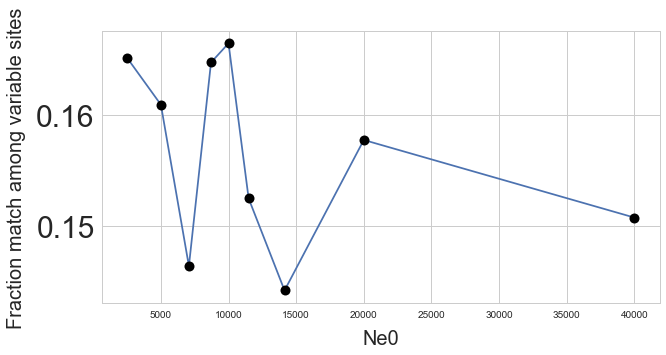

In [107]:
figout='/Users/%s/Dropbox/Science/Projects/DemographicInference/%s_vs_fracmatch_var.pdf' % (this,label)
figh=5
figw=10
sns.set(rc = {'ytick.labelsize': 30.0},style="whitegrid")
fig=plt.figure(figsize=(figw, figh))
ax = plt.subplot(111)
plt.plot(X,Fv,markersize=10,
                     linestyle='-',
                     fillstyle='none',
                    marker='o',
                    markerfacecolor='k',
                    alpha=1,
                    markeredgecolor='k',
                    markeredgewidth=0,
                    zorder=10)
plt.xlabel('%s' % label ,fontsize=20,labelpad=10)
plt.ylabel(r'Fraction match among variable sites',fontsize=20,labelpad=10)

plt.savefig(figout,bbox_inches = 'tight', pad_inches = 0.1)
#,bbox_inches = 'tight', pad_inches = 0.1
plt.show()
plt.close()

In [23]:
A = np.random.randint(0,2,size=(20,4))
a = list(map(tuple,A.tolist()))
print(a)

[(1, 1, 1, 1), (0, 1, 0, 1), (1, 1, 0, 0), (0, 0, 0, 1), (1, 0, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 1), (1, 0, 0, 0), (0, 0, 1, 0), (1, 0, 1, 1), (0, 1, 1, 0), (0, 0, 0, 0), (0, 0, 1, 1), (0, 1, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 1, 0, 0), (1, 0, 0, 1), (0, 0, 1, 0)]


In [35]:
w = tuple([1,1,0,0])
print
c = a.count(w)
print(c)

2
